# Howto Guide Permafrost Temperature Profile Data

<dev><center>Dr. Klaus G. Paul for Arctic Basecamp</center></div>

This notebook demonstrates the methods used to use the [GTN-P Arctic Database permafrost borehole temperature datasets](http://gtnpdatabase.org/boreholes) and perform data cleansing, such that it becomes possible to use these data to compute thickness of the so-called active layer, the region of permafrost that thaws, and, if the data covers it, the depth of the isothermal permafrost layer.

The [Global Terrestrial Network for Permafrost (GTN-P)](http://gtnpdatabase.org/) is a service provided by the [Arctic Portal](https://arcticportal.org/), and allows researchers to upload their observation datasets, and interested parties to use these data. The data uploaded are generally "raw" data, this notebook describes some approaches required to turn these data into information.

There is an excellnt description on how these data are acquired in section 2.5 of the [GTN-P Strategy and Implementation Plan](http://library.arcticportal.org/1938/1/GTNP_-_Implementation_Plan.pdf)

In [1]:
import pandas as pd
import zipfile
import requests
import io
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

## An example with a lot of data

We chose the [Larsbreen](http://www.gtnpdatabase.org/boreholes/view/60/) [datasets](http://www.gtnpdatabase.org/datasets/view/1491), we take one that has a lot of data, in particular, `1491`. [Larsbreen is a glacier site on Svalbrad](https://www.openstreetmap.org/way/673494772#map=6/78.175/15.552), the islands north of Norway, also known as Spitsbergen.

We do a live data download of the zip file with the data and process it directly, without storing it.

In [2]:
r = requests.get("http://gtnpdatabase.org/rest/boreholes/dlpackage/60/true")

if r.ok:
    zf = zipfile.ZipFile(io.BytesIO(r.content))
    for f in zf.filelist:
        if "1491" in f.filename:
            dfData = pd.read_csv(io.StringIO(zf.read(f).decode("ascii")))
dfData.head()

,Date/Depth,1,2,3,4,5,6,7,8,9,11
0,2008-05-08 18:00:00,-8.31,-8.18,-7.25,-6.81,-6.31,-5.68,-5.31,-5.25,-4.81,-4.75
1,2008-05-08 19:00:00,-8.31,-8.18,-7.25,-6.81,-6.25,-5.68,-5.37,-5.25,-4.81,-4.75
2,2008-05-08 20:00:00,-8.31,-8.18,-7.25,-6.81,-6.25,-5.68,-5.37,-5.25,-4.81,-4.75
3,2008-05-08 21:00:00,-8.31,-8.18,-7.25,-6.81,-6.31,-5.68,-5.37,-5.25,-4.81,-4.75
4,2008-05-08 22:00:00,-8.31,-8.18,-7.25,-6.81,-6.31,-5.68,-5.37,-5.18,-4.81,-4.75


The data columns are
* a datetime column named `Date/Depth`, which can be a bit misleading, the column itself is a datetime, which the `Depth` is pointing to the remainder columns
* a number of columns which are labelled with numbers, these are generally floating point numbers indicating the depth of the measurement, in meters. Positive numbers are depths, negative numbers are above the zero level.

Note the difference to [borehole active layer/annual thaw depth measurements](http://www.gtnpdatabase.org/activelayers), which are given in centimeters.

We want time series dataframes, so we convert the `Date/Depth` column to a datetime index.

In [3]:
dfData.index = pd.to_datetime(dfData["Date/Depth"])
dfData.index.name = None
del dfData["Date/Depth"]
dfData.head()

,1,2,3,4,5,6,7,8,9,11
2008-05-08 18:00:00,-8.31,-8.18,-7.25,-6.81,-6.31,-5.68,-5.31,-5.25,-4.81,-4.75
2008-05-08 19:00:00,-8.31,-8.18,-7.25,-6.81,-6.25,-5.68,-5.37,-5.25,-4.81,-4.75
2008-05-08 20:00:00,-8.31,-8.18,-7.25,-6.81,-6.25,-5.68,-5.37,-5.25,-4.81,-4.75
2008-05-08 21:00:00,-8.31,-8.18,-7.25,-6.81,-6.31,-5.68,-5.37,-5.25,-4.81,-4.75
2008-05-08 22:00:00,-8.31,-8.18,-7.25,-6.81,-6.31,-5.68,-5.37,-5.18,-4.81,-4.75


### Data Quality

The data are raw, and have been uploaded by multiple individuals. The example chosen specifically shows some of the challenges in data cleansing. Lets have a look at the time series data.

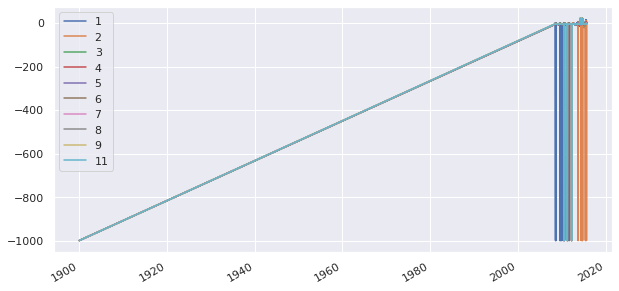

In [4]:
sns.set()
_ =dfData.plot(figsize=(10,5))

This looks like a data quality issue, well two:-
* a set of lonesome datapoints from around 1900, then a big gap
* lots of spikes out towards what seems to be a missing value indicator (which seems to also be used for the 1900-ish dataset)

Lets check:-

In [5]:
dfData.describe(percentiles=[0.01,0.5,0.99])

,1,2,3,4,5,6,7,8,9,11
count,60581.000000,60581.000000,60581.000000,60581.000000,60581.000000,60581.000000,60581.000000,60581.000000,60581.000000,60581.000000
mean,-14.546258,-5.903748,-4.315662,-4.716891,-4.835049,-4.881781,-4.993334,-5.175740,-5.169029,-5.245055
std,103.193935,46.393314,22.733320,22.668483,22.625218,22.602283,22.585054,22.551905,22.541101,22.533362
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000
1%,-999.000000,-11.430000,-9.760000,-8.952000,-8.170000,-7.810000,-7.300000,-6.500000,-5.810000,-6.000000
50%,-4.260000,-3.920000,-4.120000,-4.310000,-4.500000,-4.500000,-4.620000,-4.750000,-4.750000,-4.780000
99%,9.610000,7.190000,4.980000,2.550000,0.190000,-0.310000,-0.620000,-2.190000,-2.360000,-4.060000
max,23.170000,23.190000,23.300000,23.050000,23.260000,23.180000,23.250000,23.240000,23.130000,23.070000


Lets remove anything below 900. Well, actually, as this is degrees Celsius, lets remove any temperature below 273.15 °C.

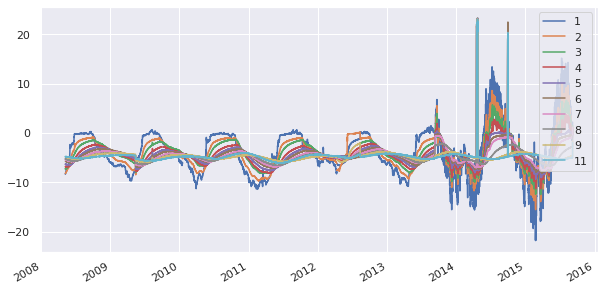

In [6]:
dfData = dfData.apply(lambda x: np.where(x < -273.15,np.nan,x))
_ = dfData.plot(figsize=(10,5))

This looks like temperatures from a borehole and seasonal variation. While we are at it, lets check for nan datasets and remove blank lines.

In [7]:
print("number of recordings {}, {} of which are completely out of range".format(len(dfData),
                                                                               len(dfData)-len(dfData.dropna(axis=0,how="all"))))
dfData.dropna(axis=0,how="all",inplace=True)

number of recordings 60581, 31 of which are completely out of range


### Permafrost Thawed / Active Layer Thickness

This is a cross section of expected measurements, taken from Wikipedia.

![](https://upload.wikimedia.org/wikipedia/commons/7/7b/Vertical_Temperature_Profile_in_Permafrost_%28English_Text%29.jpg)

Lets look at our dataset as a heatmap, well, coldmap 8-)

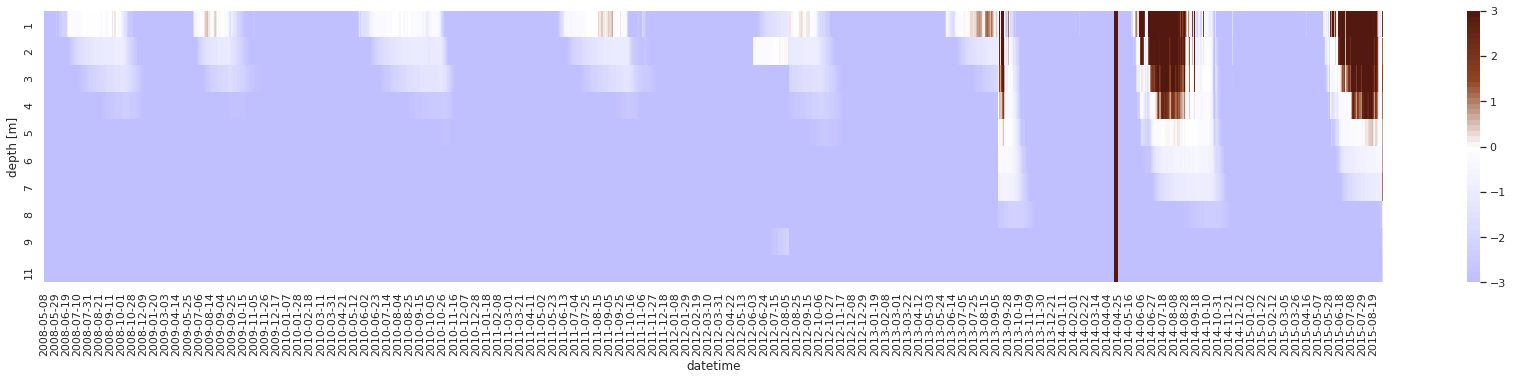

In [8]:
fig, ax = plt.subplots(figsize=(30,5))
plt.minorticks_off()
dfDataTransposed = dfData.transpose()
dfDataTransposed.columns = ["{:%Y-%m-%d}".format(d) for d in dfDataTransposed.columns]
cm = LinearSegmentedColormap.from_list("permafrost", ["#C0BFFF","#E2E2FF","#FFFFFF","#904323","#531910"], N=50)
ax = sns.heatmap(dfDataTransposed,ax=ax,cmap=cm,vmin=-3,vmax=3)
ax.set_xlabel("datetime")
_ = ax.set_ylabel("depth [m]")

So, to find the thickness of what is called the active layer (this is the thawed layer, if present), we need to look at zero crossings of the temperature, which is given in deg C. This needs to be done for every recording, i.e. every row in the dataset.

Lets pick a random datapoint that has positive and negative temps first.

In [9]:
while True:
    dfSample = dfData.sample(1)
    if dfSample.max().max()>0 and dfSample.min().min()<0:
        break
dfSample

,1,2,3,4,5,6,7,8,9,11
2013-08-26 17:00:00,0.72,-1.11,-2.11,-3.0,-3.71,-4.26,-4.65,-5.08,-5.11,-5.22


Lets plot the data and have a look at it.

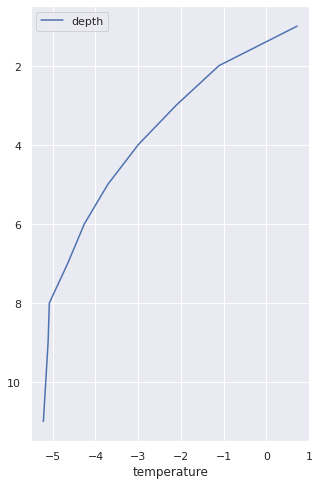

In [10]:
dfSample = dfSample.transpose()
dfSample.columns = ["temperature"]
dfSample["depth"] = pd.to_numeric(dfSample.index)
dfSample.plot(y="depth",x="temperature",figsize=(5,8)).invert_yaxis()

In [11]:
dfSample

,temperature,depth
1,0.72,1
2,-1.11,2
3,-2.11,3
4,-3.00,4
5,-3.71,5
6,-4.26,6
7,-4.65,7
8,-5.08,8
9,-5.11,9
11,-5.22,11


We need to find the zero crossing of the temperature. This can readily be done by using [Scipy's](https://scipy.org/) [ `interp1d` ](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) one dimensional interpolation routine. The x values are the temperature values observed, and the y values are the depth values.

In [12]:
f = interp1d(dfSample.temperature.values,dfSample.depth.values)
zerocrossing = f(0.)[()]
zerocrossing

1.3934426229508197

<AxesSubplot:xlabel='temperature'>

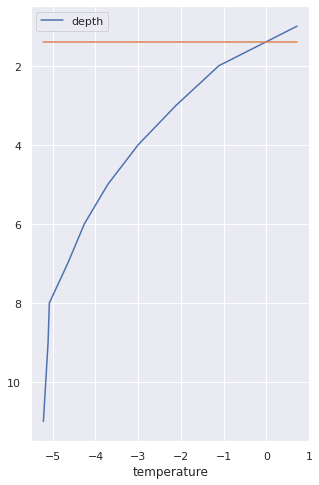

In [13]:
ax = dfSample.plot(y="depth",x="temperature",figsize=(5,8)).invert_yaxis()
sns.lineplot(x=[dfSample.temperature.min(),dfSample.temperature.max()],y=[zerocrossing,zerocrossing],ax=ax)

This seems to produce the correct results. Lets apply this to the complete dataset.

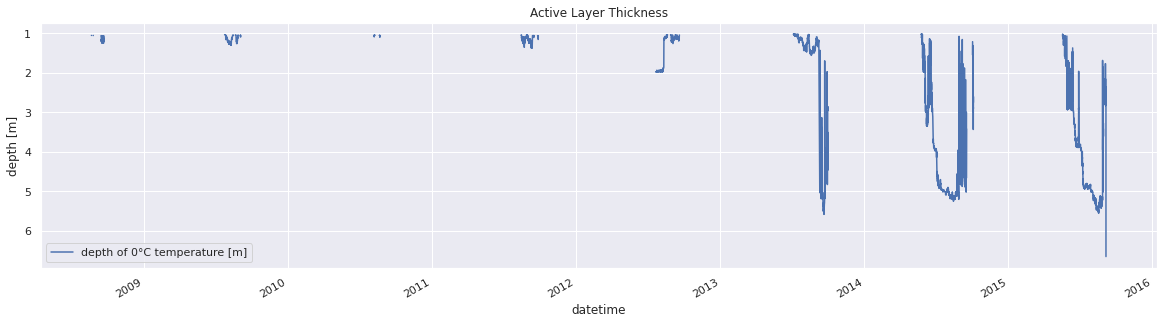

In [14]:
datetime_dates = []
zerocrossings = []
for i,r in dfData.iterrows():
    values = r.dropna()
    if values.max() < 0 or values.min() > 0:
        zerocrossing = np.nan
    else:
        f = interp1d(values,pd.to_numeric(values.index))
        zerocrossing = f(0.)[()]
    datetime_dates.append(i)
    zerocrossings.append(zerocrossing)
ax = pd.DataFrame(zerocrossings,index=datetime_dates).rename(columns={0:"depth of 0°C temperature [m]"}).plot(figsize=(20,5),title="Active Layer Thickness")
ax.invert_yaxis()
ax.set_xlabel("datetime")
_ = ax.set_ylabel("depth [m]")

### Isothermal Permafrost

In the previous section we approximated the depth of the active layer by computing the zero crossing of the measured soil temperature. Permafrost also exposes a zone called the isothermal permafrost, which is defined as the region unaffected by seasonal temperature variation. Also, according to [Smith, SL.L. et al. Thermal state of permafrost in North America: a contribution to the international polar year](https://onlinelibrary.wiley.com/doi/10.1002/ppp.690), we take a minimum isothermal temperature of -3 °C.

Lets look at the temperature map again:

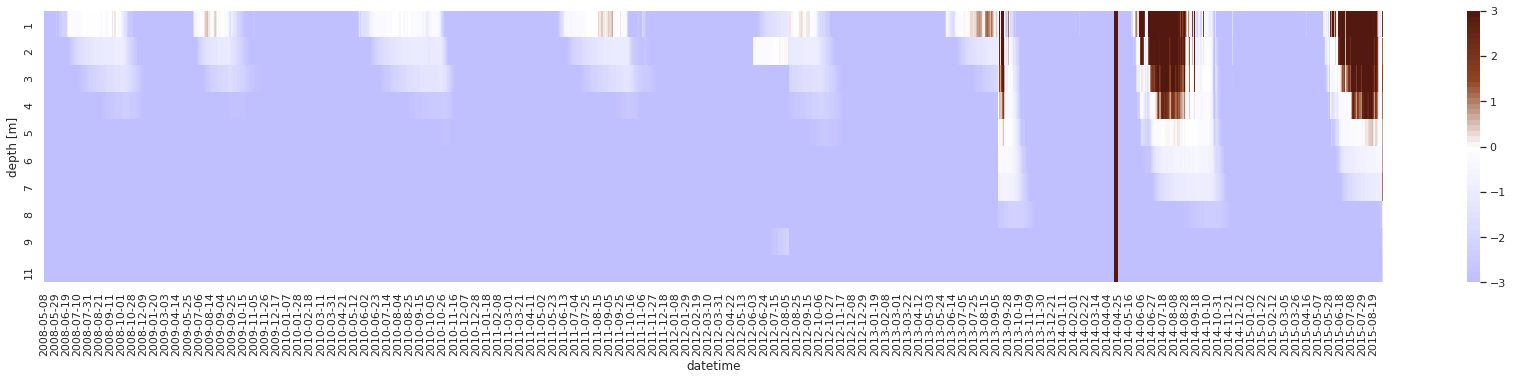

In [15]:
fig, ax = plt.subplots(figsize=(30,5))
plt.minorticks_off()
dfDataTransposed = dfData.transpose()
dfDataTransposed.columns = ["{:%Y-%m-%d}".format(d) for d in dfDataTransposed.columns]
cm = LinearSegmentedColormap.from_list("permafrost", ["#C0BFFF","#E2E2FF","#FFFFFF","#904323","#531910"], N=50)
ax = sns.heatmap(dfDataTransposed,ax=ax,cmap=cm,vmin=-3,vmax=3)
ax.set_xlabel("datetime")
_ = ax.set_ylabel("depth [m]")

### Side excursion One --- Visual Appearance

To make the display more visually attractive, a common image processing technique is interpolation of neighbouring pixel cells. We can do this in our case, as well, by applying [scipy's](https://scipy.org) [zoom](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.zoom.html) function. After re-applying meaningful column and index labels, the resulting image looks visually more pleasing.

We recommend to use this technique mainly for visual appearance, not as the basis of further analyses, which we will continue with the original dataset.

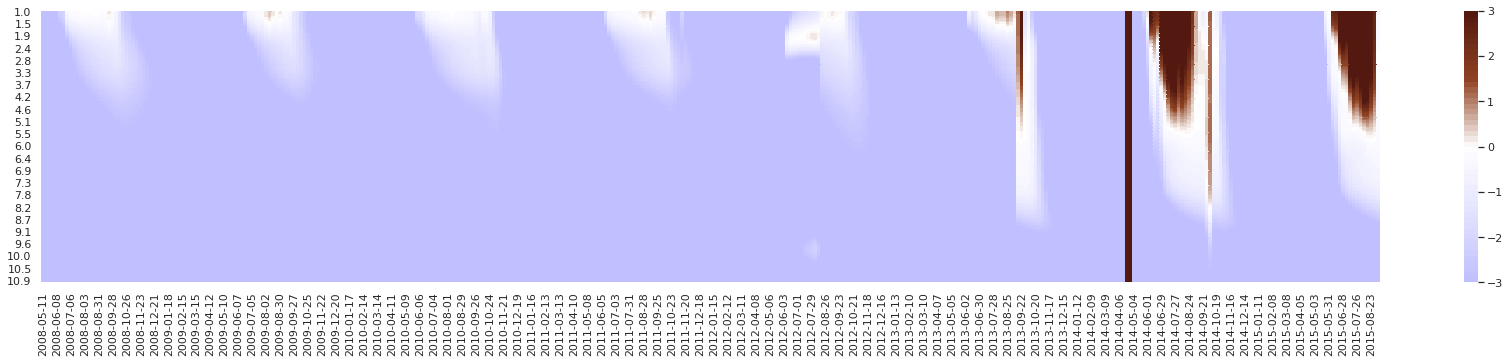

In [16]:
image = np.array(dfData.resample("1W").mean().transpose())
interpolated = zoom(image,zoom=[20,1],order=3)
dfInterpolated = pd.DataFrame(interpolated,index=["{:.1f}".format(1+d/19.9) for d in range(200)])
dfInterpolated.columns = ["{:%Y-%m-%d}".format(d) for d in dfData.resample("1W").count().index]

fig, ax = plt.subplots(figsize=(30,5))
#interpolated.columns = ["{:%Y-%m-%d}".format(d) for d in interpolated.columns]
#cm = LinearSegmentedColormap.from_list("permafrost", ["lightblue","#5CCCBB","#904323","#531910"], N=50)
ax = sns.heatmap(dfInterpolated,ax=ax,cmap=cm,vmin=-3,vmax=3)

### Side excursion Two --- Data Quality

There appears to be another data quality issue around April, 2014. Temperatures are all of a sudden around room temperature, around 20 °C. The reason for this behaviour is not clear. The data still seems to be a measured quantity, it very much looks like daily temperature variations.

<AxesSubplot:>

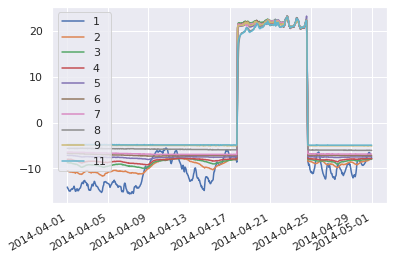

In [17]:
dfData[(pd.to_datetime("2014-04-01") <= dfData.index)&(dfData.index <= pd.to_datetime("2014-05-01"))].plot()

There appear to be two regimes of records where data are compromised, one between 2014-04-18 02:00 until 2014-04-24 14:02, and the second one, two records 2014-09-30 07:39:00 and 2014-09-30 08:00:00. One recommended way to treat this would be to remove these data from the dataset by changing them to NaN (Not a Number).

In [18]:
dfData[dfData.min(axis=1)>19]

,1,2,3,4,5,6,7,8,9,11
2014-04-18 02:00:00,21.42,21.25,21.73,21.30,21.07,21.56,21.44,19.24,21.25,19.20
2014-04-18 03:00:00,21.36,21.25,21.73,21.30,21.13,21.56,21.44,19.37,21.25,19.26
2014-04-18 04:00:00,21.42,21.25,21.80,21.30,21.07,21.62,21.38,19.49,21.25,19.32
2014-04-18 05:00:00,21.42,21.25,21.80,21.30,21.07,21.62,21.38,19.62,21.25,19.45
2014-04-18 06:00:00,21.42,21.25,21.80,21.30,21.07,21.62,21.38,19.62,21.19,19.45
...,...,...,...,...,...,...,...,...,...,...
2014-04-24 12:00:00,21.92,21.94,21.98,21.87,22.07,21.93,21.94,22.24,21.88,22.01
2014-04-24 13:00:00,22.23,22.19,22.17,22.18,22.32,22.18,22.19,22.49,22.07,22.26
2014-04-24 14:02:00,21.98,22.37,22.17,21.93,23.26,22.31,22.31,22.24,22.32,22.26
2014-09-30 07:39:00,19.30,19.25,19.36,19.30,19.51,19.24,19.50,19.37,19.32,19.45


### Isothermal Layer

To compute the depth of the isothermal layer, we need to compute the difference between consecutive measurements. That, however, would result in a large inaccuracy between the active layer depths and the isothermal zone. The isothermal zone is, according to [Smith, SL.L. et al. Thermal state of permafrost in North America: a contribution to the international polar year](https://onlinelibrary.wiley.com/doi/10.1002/ppp.690), a zone with a temperature of at most  -3 °C.

According to [Biskaborn et al., Permafrost is warming at a global scale](https://doi.org/10.1038/s41467-018-08240-4), isothermal layer exposes a temperature variation of less than 0.1 deg C.

In [19]:
# filter for below -3 deg C
dfDelta = dfData[dfData < -3.].diff(axis=0).dropna(axis=0,how="all")
dfDelta.columns = pd.to_numeric(dfDelta.columns)

# filter for 0.1 deg C between measurements
dfDeltaHaveIso = dfDelta[(-0.1 <= dfDelta)&(dfDelta <= 0.1)].dropna(axis=0,how="all")
# slightly tricky, we take the lowest index, which is equivalent to the minimum depth, as the value
dfIsoLayerDepth = pd.DataFrame(dfDeltaHaveIso.apply(lambda x : x.dropna().index.min(),axis=1)).rename(columns={0:"depth of near const temperature [°C]"})
dfIsoLayerDepth

,depth of near const temperature [°C]
2008-05-08 19:00:00,1
2008-05-08 20:00:00,1
2008-05-08 21:00:00,1
2008-05-08 22:00:00,1
2008-05-08 23:00:00,1
...,...
2015-09-06 07:00:00,9
2015-09-06 08:00:00,9
2015-09-06 09:00:00,9
2015-09-06 10:00:00,9


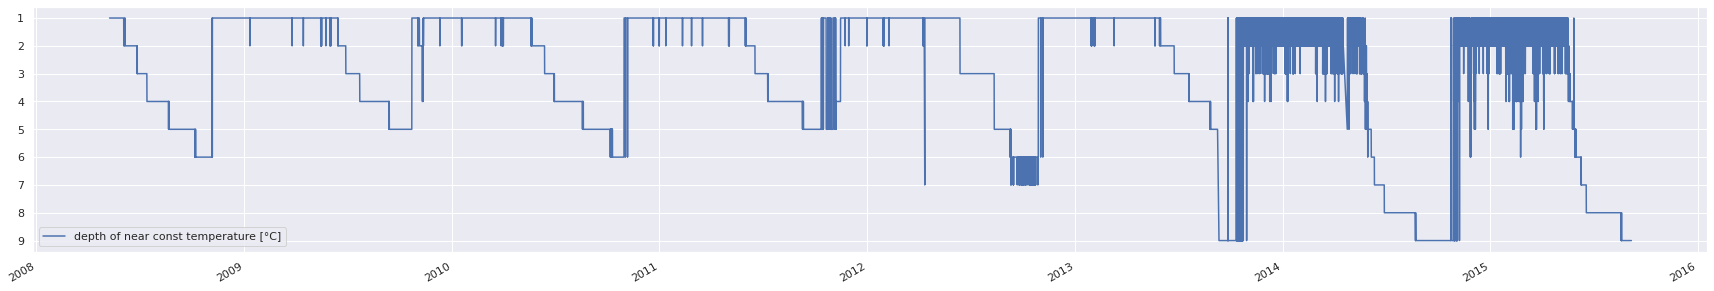

In [20]:
_ = dfIsoLayerDepth.plot(figsize=(30,5)).invert_yaxis()

The above dataset exposes some jaggedness due to the nature of the depth values (1 meter increment).

We can do a sanity check comparison of the isothermal thickness and the active layer/thaw depth values computed earlier to confirm that the active layer depth is less than the isothermal layer depth, as can be seen below.

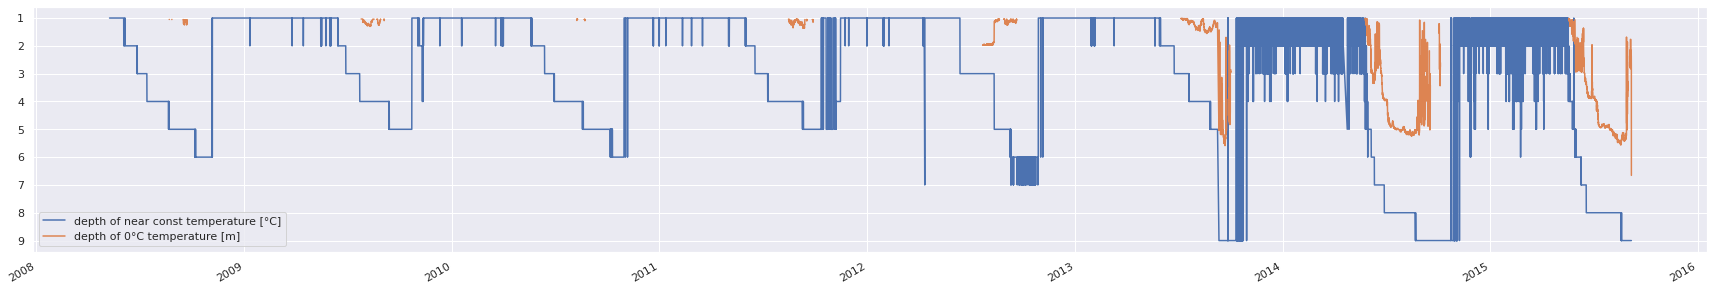

In [21]:
ax = dfIsoLayerDepth.plot(figsize=(30,5))
ax.invert_yaxis()
_ = pd.DataFrame(zerocrossings,index=datetime_dates).rename(columns={0:"depth of 0°C temperature [m]"}).plot(ax=ax)

## Handling Datasets with Sparse Data

The data format returned is a tabular csv with depth values in meters as columns, and datetimes as rows. Some datasets have varying depth values over time, which, unfortunately, makes the csv tabular format a bit difficult to use.

In [22]:
r = requests.get("http://gtnpdatabase.org/rest/boreholes/dlpackage/88/true")

In [23]:
if r.ok:
    zf = zipfile.ZipFile(io.BytesIO(r.content))
    for f in zf.filelist:
        if "656" in f.filename:
            dfData = pd.read_csv(io.StringIO(zf.read(f).decode("ascii")))
dfData.head()

,Date/Depth,-0.11,-0.08,-0.06,-0.03,-0.02,0.02,0.04,0.05,0.07,...,0.71,0.74,0.8,0.84,0.89,0.92,0.95,1.01,1.05,1.1
0,2008-06-01 00:00:00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.95,...,-999.0,-3.83,-999.0,-999.0,-4.48,-999.0,-999.0,-999.0,-999.0,-5.29
1,2008-06-02 00:00:00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,1.35,...,-999.0,-3.70,-999.0,-999.0,-4.33,-999.0,-999.0,-999.0,-999.0,-5.12
2,2008-06-03 00:00:00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.53,...,-999.0,-3.57,-999.0,-999.0,-4.18,-999.0,-999.0,-999.0,-999.0,-4.95
3,2008-06-04 00:00:00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,4.29,...,-999.0,-3.45,-999.0,-999.0,-4.04,-999.0,-999.0,-999.0,-999.0,-4.80
4,2008-06-05 00:00:00,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2.54,...,-999.0,-3.34,-999.0,-999.0,-3.93,-999.0,-999.0,-999.0,-999.0,-4.67


Lets convert the datetime column to a datetime index to get a timeseries dataframe, as before.

<AxesSubplot:>

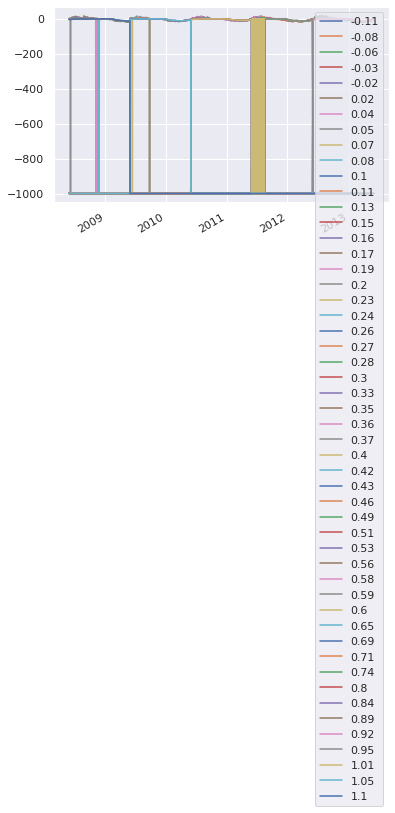

In [24]:
dfData.index = pd.to_datetime(dfData["Date/Depth"])
dfData.index.name = None
del dfData["Date/Depth"]
dfData.plot()

This plot is not very useful, as it contains way too many columns, and most of them are filled with NaN values. Remove those first, as before, by declaring values below the absolute minimum temperature as invalid.

<AxesSubplot:>

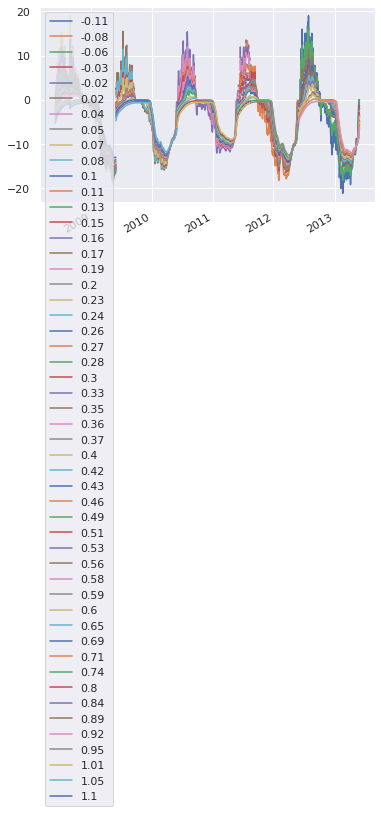

In [25]:
dfData = dfData.apply(lambda x: np.where(x < -273.15,np.nan,x))
dfData.plot()

### Resampling/Remapping

Now the data seem good, but still, there is too many columns, or depths.

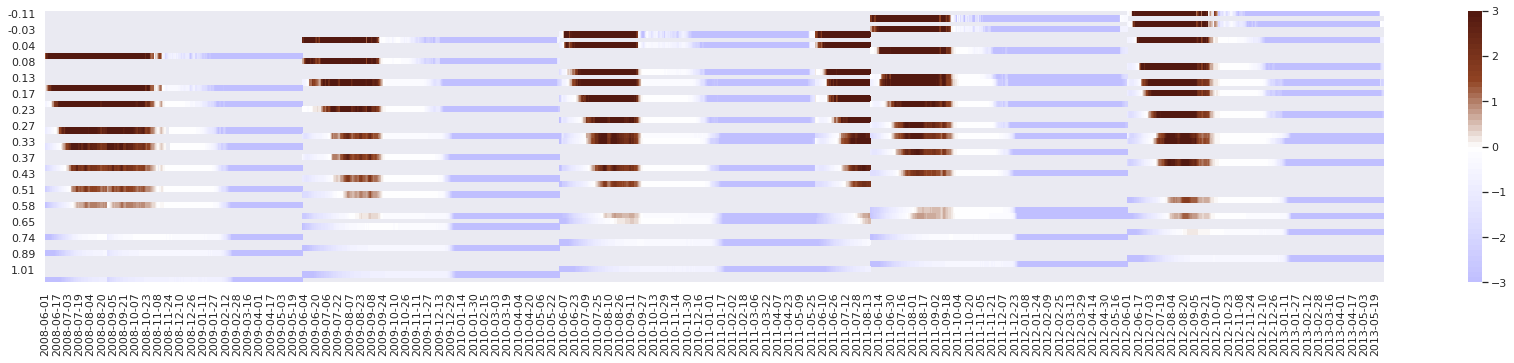

In [26]:
fig, ax = plt.subplots(figsize=(30,5))
dfDataTransposed = dfData.transpose()
dfDataTransposed.columns = ["{:%Y-%m-%d}".format(d) for d in dfDataTransposed.columns]
#cm = LinearSegmentedColormap.from_list("permafrost", ["lightblue","#5CCCBB","#904323","#531910"], N=50)
ax = sns.heatmap(dfDataTransposed,ax=ax,cmap=cm,vmin=-3,vmax=3)

Many of the entries are empty now.

In [27]:
print("{} values in {} cells ({:.1f}%).".format(dfData.count().sum(),len(dfData)*len(dfData.columns),dfData.count().sum()/(len(dfData)*len(dfData.columns))*100))
dfData.head()

24763 values in 96951 cells (25.5%).


,-0.11,-0.08,-0.06,-0.03,-0.02,0.02,0.04,0.05,0.07,0.08,...,0.71,0.74,0.8,0.84,0.89,0.92,0.95,1.01,1.05,1.1
2008-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95,NaN,...,NaN,-3.83,NaN,NaN,-4.48,NaN,NaN,NaN,NaN,-5.29
2008-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.35,NaN,...,NaN,-3.70,NaN,NaN,-4.33,NaN,NaN,NaN,NaN,-5.12
2008-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.53,NaN,...,NaN,-3.57,NaN,NaN,-4.18,NaN,NaN,NaN,NaN,-4.95
2008-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.29,NaN,...,NaN,-3.45,NaN,NaN,-4.04,NaN,NaN,NaN,NaN,-4.80
2008-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.54,NaN,...,NaN,-3.34,NaN,NaN,-3.93,NaN,NaN,NaN,NaN,-4.67


In order to look at multi-year change of thermal properties of these borehole observations, we need to remap it onto a stable vertical measurement grid. We use linear interpolation of the measured values to map them onto the grid defined.

There is no clear standard for such measurements, the [GTN-P report](http://library.arcticportal.org/1938/1/GTNP_-_Implementation_Plan.pdf) quotes [Harris et al., Permafrost monitoring in the high mountains of Europe: the PACE Project in its global context](https://onlinelibrary.wiley.com/doi/abs/10.1002/ppp.377) as suggesting 0.2, 0.4, 0.8, 1.2,
1.6, 2, 2.5, 3, 3.5, 4, 5, 7, 9, 10, 11, 13, 15, 20, 25, 30, 40, 50, 60, 70, 80, 85, 90, 95, 97.5 and
100 m. A [google search for _standard for the thermistor spacing for borehole_](https://www.google.com/search?q=standard+for+the+thermistor+spacing+for+borehole) reveals more sources such as [MANUAL FOR MONITORING AND REPORTING PERMAFROST
MEASUREMENTS](https://permafrost.gi.alaska.edu/sites/default/files/TSP_manual.pdf).

So, rather than trying to adhere to multiple standards, we re-map the value ranges to the values most commonly present in the datasets. As a rather arbitrary selection, we chose the 95% percentile of all observations. This resulted in the following depths:

-2.00, -0.50, 0.00, 0.01, 0.02, 0.10, 0.20, 0.25, 0.40, 0.50, 0.75, 0.80, 1.00, 1.20, 1.50, 1.60, 2.00, 2.50, 3.00, 3.20, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, 7.00, 7.50, 8.00, 9.00, 9.85, 10.00, 11.00, 12.00, 15.00, 20.00, 25.00 . Visual inspection of the data below also suggests 30., 40., 50., 60., 70., 80., 100., 120., and 140. m depths.

We interpolate inside the above regime, i.e. the standard depths as defined here will be clipped to match the source dataset.

The main purpose of this is to be able to automate this step without sacrificing quality of the results.

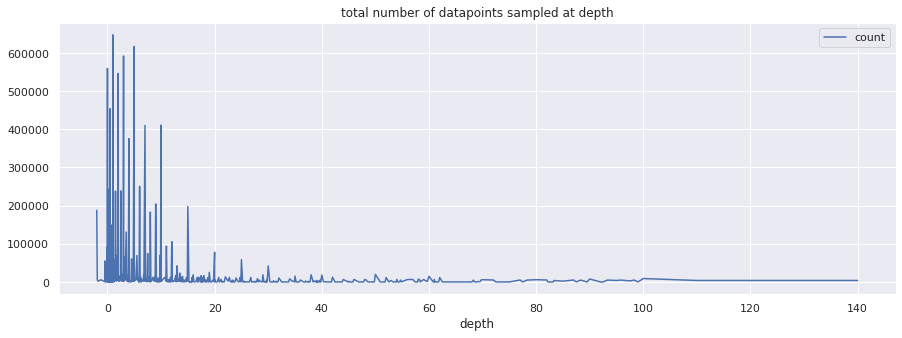

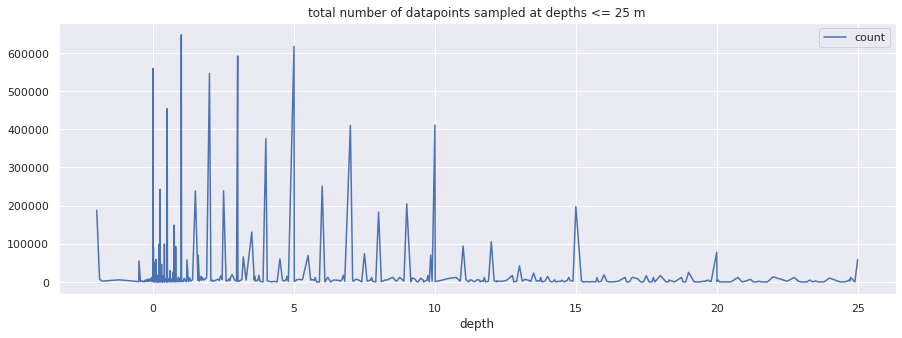

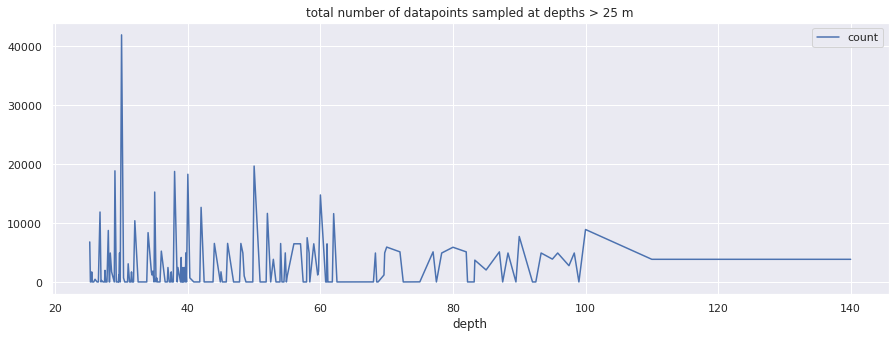

In [28]:
dfBoreholeStats = pd.read_csv("./sun/temperature_depth_stats.tsv",delimiter="\t")
dfBoreholeStats.plot.line(x="depth",y="count",figsize=(15,5), title="total number of datapoints sampled at depth")
dfBoreholeStats[dfBoreholeStats.depth<=25.].plot.line(x="depth",y="count",figsize=(15,5), title="total number of datapoints sampled at depths <= 25 m")
_ = dfBoreholeStats[dfBoreholeStats.depth>25.].plot.line(x="depth",y="count",figsize=(15,5), title="total number of datapoints sampled at depths > 25 m")

In [29]:
print(", ".join(["{:.2f}".format(pd.to_numeric(d)) for d in dfBoreholeStats[dfBoreholeStats["count"] >= dfBoreholeStats["count"].quantile(0.95)].depth.values]))

-2.00, -0.50, 0.00, 0.01, 0.02, 0.10, 0.20, 0.25, 0.40, 0.50, 0.75, 0.80, 1.00, 1.20, 1.50, 1.60, 2.00, 2.50, 3.00, 3.20, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, 7.00, 7.50, 8.00, 9.00, 9.85, 10.00, 11.00, 12.00, 15.00, 20.00, 25.00


In [30]:
standard_depths = np.array([-2.00, -0.50, 0.00, 0.01, 0.02, 0.10, 0.20, 0.25, 0.40, 0.50, 0.75, 0.80, 1.00, 
                            1.20, 1.50, 1.60, 2.00, 2.50, 3.00, 3.20, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, 
                            7.00, 7.50, 8.00, 9.00, 9.85, 10.00, 11.00, 12.00, 15.00, 20.00, 25.00, 30.0, 
                            40.0, 50.0, 60.0, 70.0, 80.0, 100.0, 120.0, 140.0])

depths = pd.to_numeric(dfData.columns)
#model = [x for x in standard_depths if x <= depths.max() and depths.min() <= x]
model = standard_depths[(depths.min() <= standard_depths)&(standard_depths<=depths.max())]

alldata = {}

for i,r in dfData.iterrows():
    measurements = pd.Series(r.values,index=depths).dropna()
    f = interp1d(measurements.index.values,measurements.values,fill_value="extrapolate")
    interpolated_values = f(model)[()]
    alldata[i] = interpolated_values
    
ddf = pd.DataFrame(alldata).transpose()
ddf.columns = model

ddf

,0.00,0.01,0.02,0.10,0.20,0.25,0.40,0.50,0.75,0.80,1.00
2008-06-01,1.650000,1.550000,1.450000,0.650000,-0.560000,-0.853750,-1.861429,-2.336667,-3.873333,-4.090000,-4.904286
2008-06-02,2.298889,2.163333,2.027778,0.943333,-0.540000,-0.821250,-1.794286,-2.248889,-3.742000,-3.952000,-4.743810
2008-06-03,4.108889,3.883333,3.657778,1.853333,-0.490000,-0.758750,-1.710000,-2.158889,-3.610667,-3.814000,-4.583333
2008-06-04,6.568889,6.243333,5.917778,3.313333,-0.410000,-0.685000,-1.630000,-2.078889,-3.489333,-3.686000,-4.438095
2008-06-05,3.706667,3.540000,3.373333,2.040000,-0.340000,-0.615000,-1.552857,-1.981111,-3.379333,-3.576000,-4.317619
...,...,...,...,...,...,...,...,...,...,...,...
2013-05-27,-0.830525,-0.950662,-1.070800,-2.187200,-3.638886,-3.950050,-5.765900,-6.443775,-7.673443,-7.793871,-8.275586
2013-05-28,-0.651350,-0.741925,-0.832500,-1.642200,-2.831200,-3.450017,-4.850400,-5.594337,-7.014986,-7.165843,-7.769271
2013-05-29,-0.601500,-0.681500,-0.761500,-1.466800,-2.511743,-3.126333,-4.351600,-5.071100,-6.491890,-6.653629,-7.300581
2013-05-30,-0.579025,-0.652262,-0.725500,-1.362500,-2.311500,-2.893650,-4.009300,-4.693362,-6.074695,-6.238814,-6.895290


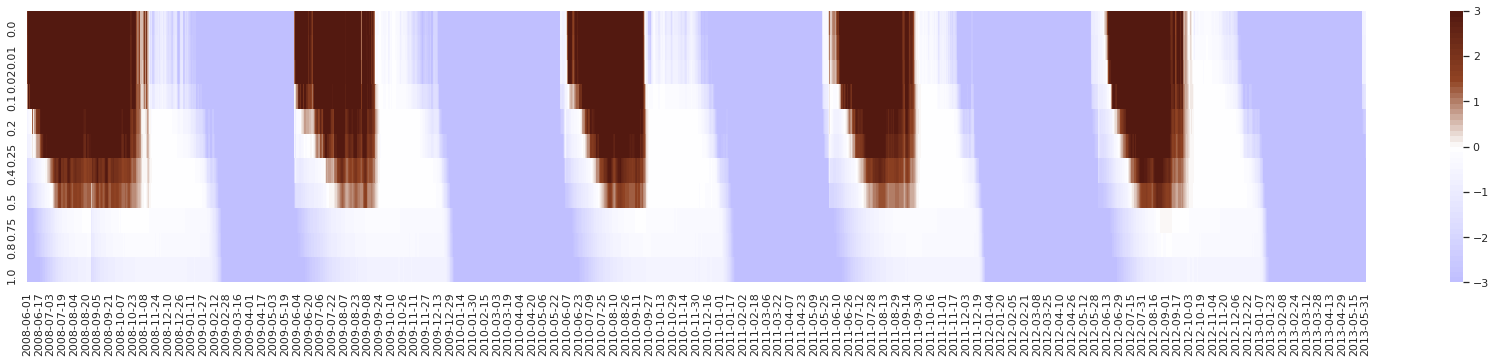

In [31]:
fig, ax = plt.subplots(figsize=(30,5))

dfDataTransposed = ddf.transpose()
dfDataTransposed.columns = ["{:%Y-%m-%d}".format(d) for d in dfDataTransposed.columns]
#cm = LinearSegmentedColormap.from_list("permafrost", ["lightblue","#5CCCBB","#904323","#531910"], N=50)
ax = sns.heatmap(dfDataTransposed,ax=ax,cmap=cm,vmin=-3,vmax=3)

## Storing Data

Lets look back at the original data, which had only about 25% of all cells being populated with measured values. It is not practical to store the data in columns representing depths. As a data store, we use a key-value pattern, in fact, multiple keys and one value. Keys are
* datetime
* depth
* dataset ID

and the value is temperature. This can readily be stored in a SQL table, which is a good choice, as the data we deal with are highly structured. One could also use a NoSQL store, but, ultimately, the complexities of dealing with varying depths stay in the business logic.

The way to transform the data is, from tabular data to keys,value to use [`pandas.stack`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html) . For reading the data back into a tabular data frame, use [`pandas.pivot_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html).

In [32]:
dfStacked = dfData.stack().reset_index().rename(columns={"level_0":"datetime_date","level_1":"depth",0:"temperature"})
dfStacked["dataset"] = "656"
dfStacked.head()

,datetime_date,depth,temperature,dataset
0,2008-06-01,0.07,0.95,656
1,2008-06-01,0.16,0.05,656
2,2008-06-01,0.2,-0.56,656
3,2008-06-01,0.28,-1.03,656
4,2008-06-01,0.35,-1.54,656


In [33]:
# We are not doing a SQL store in this example
# dfStacked.to_sql("table",con=conn)
# dfStacked = pd.read_sql("SELECT * FROM table WHERE dataset='656'")

In [34]:
dfStacked.pivot_table(index="datetime_date",values="temperature",columns="depth").head()

depth,-0.02,-0.03,-0.06,-0.08,-0.11,0.02,0.04,0.05,0.07,0.08,...,0.71,0.74,0.8,0.84,0.89,0.92,0.95,1.01,1.05,1.1
datetime_date,,,,,,,,,,,,,,,,,,,,,
2008-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95,NaN,...,NaN,-3.83,NaN,NaN,-4.48,NaN,NaN,NaN,NaN,-5.29
2008-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.35,NaN,...,NaN,-3.70,NaN,NaN,-4.33,NaN,NaN,NaN,NaN,-5.12
2008-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.53,NaN,...,NaN,-3.57,NaN,NaN,-4.18,NaN,NaN,NaN,NaN,-4.95
2008-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.29,NaN,...,NaN,-3.45,NaN,NaN,-4.04,NaN,NaN,NaN,NaN,-4.80
2008-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.54,NaN,...,NaN,-3.34,NaN,NaN,-3.93,NaN,NaN,NaN,NaN,-4.67


# Dealing with Resolution Loss

A few datasets, unfortunately, were found to have duplicate timestamps. The cause is not clear, what has been observed in the past, though, is an unfortunate combination of formatting cells as dates (i.e., YYYY-mm-dd) instead of timestamps (YYYY-mm-dd HH:MM), then storing the data as csv. Some spreadsheet tools (MS Excel being one of them) then store the csv in reduced resolution, i.e. a timestamp (date plus time) may be clipped to a date.

In [35]:
r = requests.get("http://gtnpdatabase.org/rest/boreholes/dlpackage/118/true") #("http://gtnpdatabase.org/rest/boreholes/dlpackage/1191/true")

The data initially looks inconspicuous and the Date column appears to have datetime timestamps.

In [36]:
if r.ok:
    zf = zipfile.ZipFile(io.BytesIO(r.content))
    for f in zf.filelist:
        if "618" in f.filename:
            dfData = pd.read_csv(io.StringIO(zf.read(f).decode("ascii")))

dfData.head()

,Date/Depth,0.02,0.05,0.07,0.075,0.125,0.15,0.16,0.223,0.28,0.32,0.375,0.47,0.525,0.61,0.673,0.76,0.823,1.01,1.07
0,2009-06-25 00:00:00,-999.0,-999.0,-999.0,-0.16,-0.49,-999.0,-999.0,-0.99,-999.0,-999.0,-1.64,-999.0,-2.12,-999.0,-2.71,-999.0,-3.20,-999.0,-3.89
1,2009-06-26 00:00:00,-999.0,-999.0,-999.0,-0.15,-0.49,-999.0,-999.0,-0.99,-999.0,-999.0,-1.64,-999.0,-2.10,-999.0,-2.67,-999.0,-3.16,-999.0,-3.85
2,2009-06-27 00:00:00,-999.0,-999.0,-999.0,0.05,-0.46,-999.0,-999.0,-0.96,-999.0,-999.0,-1.61,-999.0,-2.08,-999.0,-2.64,-999.0,-3.13,-999.0,-3.81
3,2009-06-28 00:00:00,-999.0,-999.0,-999.0,0.24,-0.43,-999.0,-999.0,-0.95,-999.0,-999.0,-1.59,-999.0,-2.05,-999.0,-2.61,-999.0,-3.09,-999.0,-3.77
4,2009-06-29 00:00:00,-999.0,-999.0,-999.0,0.32,-0.41,-999.0,-999.0,-0.93,-999.0,-999.0,-1.58,-999.0,-2.03,-999.0,-2.60,-999.0,-3.06,-999.0,-3.73


One way of computing duplication is to call `pandas.DataFrame.duplicated`, another is to check if `len(DataFrame)>len(DataFrame["Date/Depth"]`. It turns out there is a reasonable number of duplicates.

In [37]:
print("{} records, {} of which are duplicate Date/Depth fields".format(len(dfData),dfData.duplicated(subset=["Date/Depth"],keep=False).sum()))
dfData[dfData.duplicated(subset=["Date/Depth"],keep=False)].sort_values("Date/Depth")

1511 records, 320 of which are duplicate Date/Depth fields


,Date/Depth,0.02,0.05,0.07,0.075,0.125,0.15,0.16,0.223,0.28,0.32,0.375,0.47,0.525,0.61,0.673,0.76,0.823,1.01,1.07
341,2010-06-01 00:00:00,-999.0,-1.070,-999.0,-1.040,-1.680,-1.670,-999.0,-2.630,-2.780,-999.0,-4.020,-999.0,-4.920,-999.0,-5.870,-999.0,-6.610,-999.0,-7.510
426,2010-06-01 00:00:00,-999.0,-1.070,-999.0,-1.040,-1.680,-1.670,-999.0,-2.630,-2.780,-999.0,-4.020,-999.0,-4.920,-999.0,-5.870,-999.0,-6.610,-999.0,-7.510
342,2010-06-02 00:00:00,-999.0,-0.950,-999.0,-0.920,-1.530,-1.510,-999.0,-2.430,-2.570,-999.0,-3.760,-999.0,-4.640,-999.0,-5.580,-999.0,-6.320,-999.0,-7.240
427,2010-06-02 00:00:00,-999.0,-0.950,-999.0,-0.920,-1.530,-1.510,-999.0,-2.430,-2.570,-999.0,-3.760,-999.0,-4.640,-999.0,-5.580,-999.0,-6.320,-999.0,-7.240
343,2010-06-03 00:00:00,-999.0,-0.880,-999.0,-0.880,-1.430,-1.400,-999.0,-2.280,-2.400,-999.0,-3.550,-999.0,-4.400,-999.0,-5.330,-999.0,-6.060,-999.0,-6.990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2011-08-12 00:00:00,-999.0,4.250,-999.0,4.062,2.733,3.409,-999.0,1.163,1.825,-999.0,-0.573,-999.0,-0.978,-999.0,-1.467,-999.0,-1.880,-999.0,-2.471
864,2011-08-13 00:00:00,-999.0,4.310,-999.0,4.410,3.060,3.440,-999.0,1.440,1.840,-999.0,-0.340,-999.0,-0.760,-999.0,-1.240,-999.0,-1.640,-999.0,-2.230
939,2011-08-13 00:00:00,-999.0,4.313,-999.0,4.173,2.843,3.438,-999.0,1.225,1.837,-999.0,-0.559,-999.0,-0.977,-999.0,-1.454,-999.0,-1.856,-999.0,-2.451
865,2011-08-14 00:00:00,-999.0,4.030,-999.0,3.720,2.790,3.300,-999.0,1.430,1.830,-999.0,-0.310,-999.0,-0.720,-999.0,-1.180,-999.0,-1.600,-999.0,-2.180


To deal with this, we loop through the duplicate entries and compute the mean of the two values. For some data files, it seems logical to pad the data with a synthetic hour entry, as it appears that one reading was taken 12 hrs before the other, but this would result in speculation.

In addition, we are interested in longer term drifts of permafrost temperatures

In [38]:
dfData.index = pd.to_datetime(dfData["Date/Depth"])
dfData.index.name = None
del dfData["Date/Depth"]
dfData = dfData.apply(lambda x: np.where(x < -273.15,np.nan,x))
dfData = dfData.dropna(axis=0,how="all")

alldata = []
for dt in dfData.index.unique():
    ddf = dfData[dfData.index == dt]
    newvalue = dict(zip(list(ddf.columns),ddf.values[0]))
    newvalue["datetime_date"] = dt
    alldata.append(newvalue)
    
dfData = pd.DataFrame(alldata)#.set_index("datetime_date")
#dfData.index.name = None
dfData

,0.02,0.05,0.07,0.075,0.125,0.15,0.16,0.223,0.28,0.32,0.375,0.47,0.525,0.61,0.673,0.76,0.823,1.01,1.07,datetime_date
0,NaN,NaN,NaN,-0.16,-0.49,NaN,NaN,-0.99,NaN,NaN,-1.64,NaN,-2.12,NaN,-2.71,NaN,-3.20,NaN,-3.89,2009-06-25
1,NaN,NaN,NaN,-0.15,-0.49,NaN,NaN,-0.99,NaN,NaN,-1.64,NaN,-2.10,NaN,-2.67,NaN,-3.16,NaN,-3.85,2009-06-26
2,NaN,NaN,NaN,0.05,-0.46,NaN,NaN,-0.96,NaN,NaN,-1.61,NaN,-2.08,NaN,-2.64,NaN,-3.13,NaN,-3.81,2009-06-27
3,NaN,NaN,NaN,0.24,-0.43,NaN,NaN,-0.95,NaN,NaN,-1.59,NaN,-2.05,NaN,-2.61,NaN,-3.09,NaN,-3.77,2009-06-28
4,NaN,NaN,NaN,0.32,-0.41,NaN,NaN,-0.93,NaN,NaN,-1.58,NaN,-2.03,NaN,-2.60,NaN,-3.06,NaN,-3.73,2009-06-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1268,-2.7104,-1.5204,-4.5956,NaN,NaN,-2.2250,-5.6737,NaN,-3.6089,-6.7580,NaN,-7.6085,NaN,-8.6192,NaN,-0.0344,NaN,0.1077,NaN,2013-05-27
1269,-2.4790,-1.3211,-4.2536,NaN,NaN,-1.9659,-5.2916,NaN,-3.2538,-6.3635,NaN,-7.2211,NaN,-8.2646,NaN,-0.0446,NaN,-0.3998,NaN,2013-05-28
1270,-2.2808,-1.1806,-3.9688,NaN,NaN,-1.7903,-4.9710,NaN,-2.9980,-6.0200,NaN,-6.8730,NaN,-7.9328,NaN,-0.0380,NaN,0.5667,NaN,2013-05-29
1271,-2.1139,-1.0570,-3.7322,NaN,NaN,-1.6403,-4.6996,NaN,-2.7869,-5.7245,NaN,-6.5677,NaN,-7.6319,NaN,-0.0386,NaN,-0.4715,NaN,2013-05-30


In [39]:
print("{} records, {} of which are duplicate Date/Depth fields".format(len(dfData),dfData.duplicated(subset="datetime_date",keep=False).sum()))

1273 records, 0 of which are duplicate Date/Depth fields
